In [1]:
%matplotlib inline

import pandas as pd
import os
import glob
import numpy as np
import scanpy as sc

import seaborn as sns
import matplotlib.pyplot as plt

# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
plt.rcParams['savefig.dpi']=600
sns.set_style("ticks")

In [2]:
def txt2adata(filename='/home/ngr4/scratch60/rpczi/GSE161382_counts_matrix.txt', 
              metadata_filename='/home/ngr4/scratch60/rpczi/GSE161382_metadata.txt',
              save=None):
    '''
    Assumes:
      1. txt file is \t separated
      2. txt file is counts data as genes x cell_id
      3. metadata file is space sepearated, sep=' '
    
    Arguments:
      1. 
    '''
    txtdata = pd.read_csv(filename, sep='\t', index_col=0)
    md = pd.read_csv(metadata_filename, sep=' ')
    adata = sc.AnnData(X=txtdata.T)
    adata.obs = adata.obs.merge(md, left_index=True, right_index=True)
    if save is not None:
        adata.write(save)
    return adata


In [3]:
init_load = False

if init_load:
    adata = txt2adata(save='/home/ngr4/scratch60/rpczi/lungmap.h5ad')
else: 
    adata = sc.read('/home/ngr4/scratch60/rpczi/lungmap.h5ad')
    rpdata = sc.read('/home/ngr4/project/collabs/grants/czi_rp_2103/data/rpczi_cpb.h5ad')

In [9]:
adata = adata.concatenate(rpdata, batch_key='source', batch_categories=['LungMap', 'CPB'])
adata

AnnData object with n_obs × n_vars = 70386 × 26566
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'age', 'sex', 'donor', 'batch', 'celltype', 'lineage', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'source'
    var: 'gene_ids-CPB', 'feature_types-CPB', 'n_cells_by_counts-CPB', 'mean_counts-CPB', 'log1p_mean_counts-CPB', 'pct_dropout_by_counts-CPB', 'total_counts-CPB', 'log1p_total_counts-CPB'

In [10]:
sc.pp.recipe_zheng17(adata)
adata

/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [15]:
adata.obs.loc[adata.obs['source']=='LungMap', 'batch'] = 'LM' + adata.obs.loc[adata.obs['source']=='LungMap', 'age'].astype(str) + adata.obs.loc[adata.obs['source']=='LungMap', 'sex'].astype(str)
adata.obs['age'] = adata.obs['age'].astype(str)
adata.obs['sex'] = adata.obs['sex'].astype(str)
adata.obs.loc[adata.obs['batch']=='CPB1', 'age'] = '7mos'
adata.obs.loc[adata.obs['batch']=='CPB2', 'age'] = '7mos'
adata.obs.loc[adata.obs['batch']=='CPB3', 'age'] = '8y'
adata.obs.loc[adata.obs['batch']=='CPB4', 'age'] = '6mos'
adata.obs.loc[adata.obs['batch']=='CPB5', 'age'] = '11mos'
adata.obs.loc[adata.obs['batch']=='CPB6', 'age'] = '21mos'
adata.obs.loc[adata.obs['batch']=='CPBX', 'age'] = '11mos'
adata.obs.loc[adata.obs['batch']=='CPB1', 'sex'] = 'M'
adata.obs.loc[adata.obs['batch']=='CPB2', 'sex'] = 'F'
adata.obs.loc[adata.obs['batch']=='CPB3', 'sex'] = 'F'
adata.obs.loc[adata.obs['batch']=='CPB4', 'sex'] = 'M'
adata.obs.loc[adata.obs['batch']=='CPB5', 'sex'] = 'F'
adata.obs.loc[adata.obs['batch']=='CPB6', 'sex'] = 'M'
adata.obs.loc[adata.obs['batch']=='CPBX', 'sex'] = 'M'

In [16]:
sc.tl.pca(adata)

/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


In [27]:
sc.external.pp.bbknn(adata, neighbors_within_batch=int(100/adata.obs.batch.unique().shape[0]), n_pcs=50)

/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


In [28]:
sc.tl.umap(adata)

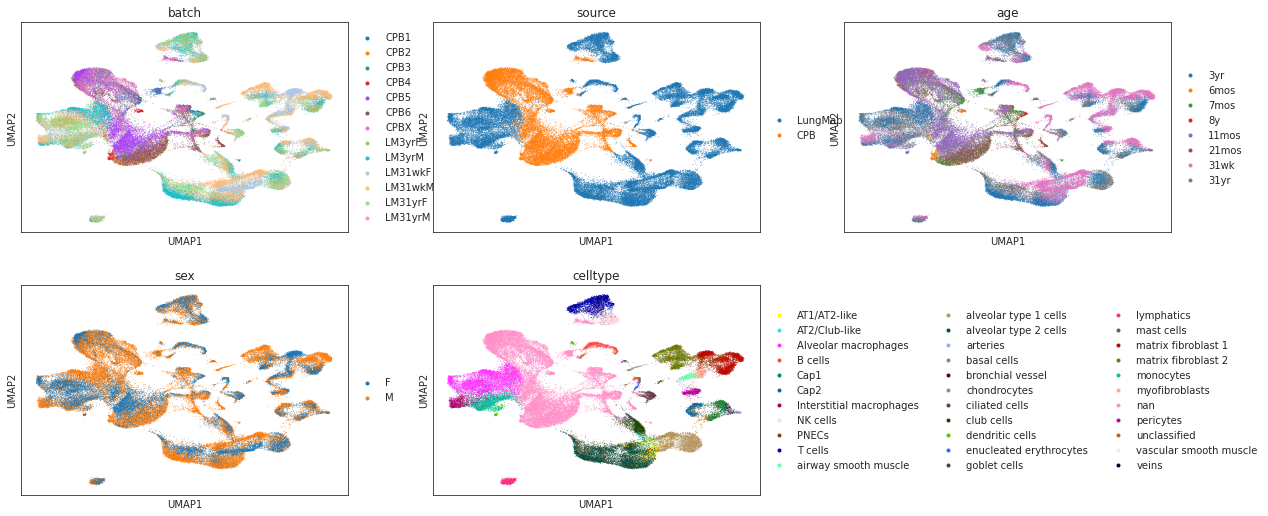

In [29]:
sc.pl.umap(adata, color=['batch', 'source', 'age',
                         'sex', 'celltype'], ncols=3)

In [34]:
mnn_corrected = sc.external.pp.mnn_correct(*[adata[adata.obs['batch']==b, :] for b in adata.obs['batch'].unique()], batch_key='mnn_batch')

/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: No implementation of function Function(<function norm at 0x2b12eed46680>) found for signature:
 
 >>> norm(x=array(float32, 2d, A), axis=Literal[int](1))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'norm_impl': File: numba/np/linalg.py: Line 2352.
    With argument(s): '(x=array(float32, 2d, A), axis=int64)':
   Rejected as the implementation raised a specific error:
     TypeError: norm_impl() got an unexpected keywo

Performing cosine normalization...


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: No implementation of function Function(<function norm at 0x2b12eed46680>) found for signature:
 
 >>> norm(x=array(float32, 2d, A), axis=Literal[int](1))
 
There are 2 candidate implementations:
    - Of which 2 did not match due to:
    Overload in function 'norm_impl': File: numba/np/linalg.py: Line 2352.
      With argument(s): '(x=array(float32, 2d, A), axis=int64)':
     Rejected as the implementation raised a specific error:
       TypeError: norm_impl() got an unexpected keyword argument 'x'
  raised from /gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/numba/core/typing/templates.py:710

During: resolving callee type: Function(<function norm at 0x2b12eed46680>)
During: typing of call at /gpfs/ycga/project/dijk/ngr4/conda_e

Starting MNN correct iteration. Reference batch: 0
Step 1 of 12: processing batch 1
  Looking for MNNs...


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/mnnpy/utils.py:88: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "find_mutual_nn" failed type inference due to: non-precise type pyobject
During: typing of argument at /gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/mnnpy/utils.py (94)

File "../../../../conda_envs/rnavel/lib/python3.7/site-packages/mnnpy/utils.py", line 94:
def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    <source elided>
    mutual_2 = []
    for index_2 in range(data2.shape[0]):
    ^

  @jit((float32[:, :], float32[:, :], int8, int8, int8))
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/numba/core/object_mode_passes.py:152: NumbaWarning: Function "find_mutual_nn" was compiled in object mode without forceobj=True.

File "../../../../conda_envs/rnavel/lib/python3.7/site-packages/mnnpy/utils.py", line 94:
def find_mutual_nn(data1,

  Computing correction vectors...


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'mnn2' of function 'compute_correction'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../conda_envs/rnavel/lib/python3.7/site-packages/mnnpy/utils.py", line 107:
def compute_correction(data1, data2, mnn1, mnn2, data2_or_raw2, sigma):
    <source elided>
    vect_reduced = np.zeros((data2.shape[0], vect.shape[1]), dtype=np.float32)
    for index, ve in zip(mnn2, vect):
    ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


  Adjusting variance...
  Applying correction...
Step 2 of 12: processing batch 2
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 3 of 12: processing batch 3
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 4 of 12: processing batch 4
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 5 of 12: processing batch 5
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 6 of 12: processing batch 6
  Looking for MNNs...
  Computing correction vectors...


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/mnnpy/utils.py:102: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "compute_correction" failed type inference due to: non-precise type pyobject
During: typing of argument at /gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/mnnpy/utils.py (107)

File "../../../../conda_envs/rnavel/lib/python3.7/site-packages/mnnpy/utils.py", line 107:
def compute_correction(data1, data2, mnn1, mnn2, data2_or_raw2, sigma):
    <source elided>
    vect_reduced = np.zeros((data2.shape[0], vect.shape[1]), dtype=np.float32)
    for index, ve in zip(mnn2, vect):
    ^

  @jit(float32[:, :](float32[:, :], float32[:, :], int32[:], int32[:], float32[:, :], float32))
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/numba/core/object_mode_passes.py:152: NumbaWarning: Function "compute_correction" was compiled in object mode without fo

IndexError: arrays used as indices must be of integer (or boolean) type

In [35]:
sc.pp.combat(adata)

/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


In [36]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

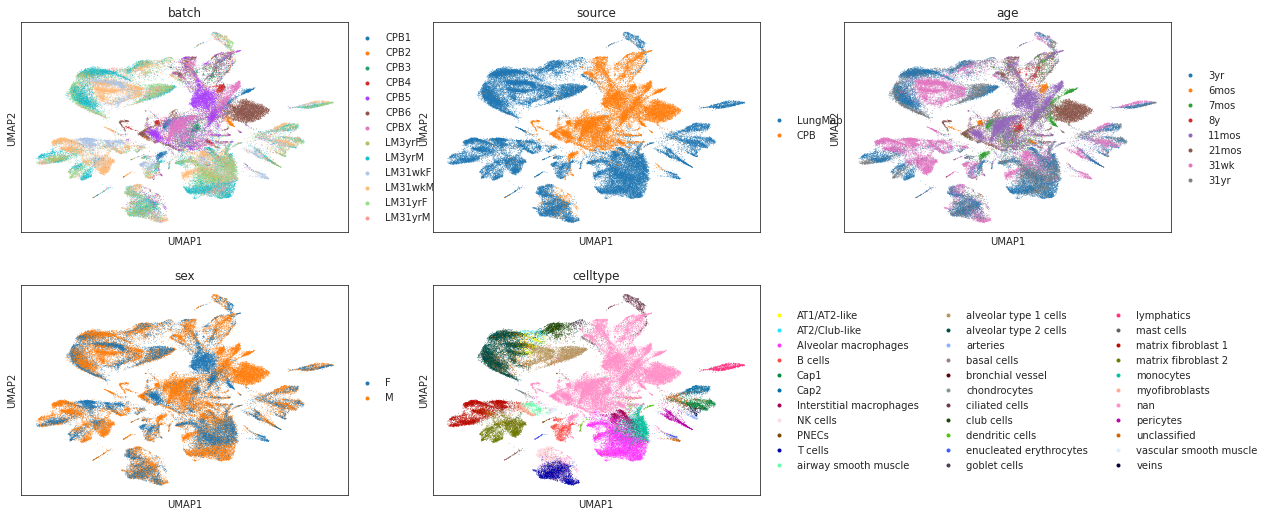

In [37]:
sc.pl.umap(adata, color=['batch', 'source', 'age',
                         'sex', 'celltype'], ncols=3)

In [40]:
sc.external.pp.harmony_integrate(adata, 'batch')

2021-03-16 12:45:00,241 - harmonypy - INFO - Iteration 1 of 10
2021-03-16 12:45:29,138 - harmonypy - INFO - Iteration 2 of 10
2021-03-16 12:45:59,713 - harmonypy - INFO - Iteration 3 of 10
2021-03-16 12:46:30,252 - harmonypy - INFO - Iteration 4 of 10
2021-03-16 12:46:59,713 - harmonypy - INFO - Iteration 5 of 10
2021-03-16 12:47:22,062 - harmonypy - INFO - Iteration 6 of 10
2021-03-16 12:47:52,329 - harmonypy - INFO - Converged after 6 iterations


In [41]:
adata

AnnData object with n_obs × n_vars = 70386 × 1000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'age', 'sex', 'donor', 'batch', 'celltype', 'lineage', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'source', 'n_counts_all'
    var: 'gene_ids-CPB', 'feature_types-CPB', 'n_cells_by_counts-CPB', 'mean_counts-CPB', 'log1p_mean_counts-CPB', 'pct_dropout_by_counts-CPB', 'total_counts-CPB', 'log1p_total_counts-CPB', 'n_counts', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'batch_colors', 'source_colors', 'age_colors', 'sex_colors', 'celltype_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [51]:
import phate
data = np.random.normal(size=(100, 10))
phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(data)

Calculating PHATE...
  Running PHATE on 100 cells and 10 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.04 seconds.
  Calculating optimal t...
  Calculated optimal t in 0.01 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.04 seconds.
Calculated PHATE in 0.14 seconds.


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/graphtools/base.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=100 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [56]:
import graphtools as gt

In [58]:
G = gt.Graph(ada, kernel_symm='mnn')

/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/graphtools/base.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/graphtools/base.py:536: UserWarning: kernel_symm='mnn' but theta not given. Defaulting to theta=1.
  "Defaulting to theta={}.".format(self.theta)
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=100 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [59]:
adata.obsm['X_pca']

array([[-1.5704703 , -2.8993936 , -0.4706754 , ..., -1.2142793 ,
        -0.39059356, -0.8227852 ],
       [-1.0557137 , -1.6599617 , -1.365658  , ...,  0.05290144,
        -0.10584663, -0.7414685 ],
       [-2.000123  , -3.07478   ,  0.24278857, ...,  0.91273993,
         0.7304802 ,  0.18488683],
       ...,
       [-0.8312918 ,  0.03373152, -0.41892293, ...,  0.02108533,
         0.10016841, -0.06626239],
       [-0.3032704 , -0.02834595, -0.74417996, ...,  0.18998854,
        -0.06240163,  0.10572444],
       [-0.9025445 , -0.02416147, -0.16868663, ..., -0.6346571 ,
        -0.15505768, -0.42692545]], dtype=float32)

In [69]:
G = gt.Graph(adata.obsm['X_pca'], 
             kernel_symm='mnn', 
             theta=0.1,
             sample_idx=adata.obs['batch'].map({v:i for i,v in enumerate(np.sort(adata.obs.batch.unique()))}))

/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/graphtools/base.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=2400 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/graphtools/base.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=472 as keyword args. Fr

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 70386 cells.
  Calculating graph and diffusion operator...


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/graphtools/base.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):


  Calculated graph and diffusion operator in 7.91 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 110.67 seconds.
    Calculating KMeans...
    Calculated KMeans in 32.32 seconds.
  Calculated landmark operator in 152.32 seconds.
  Calculating optimal t...
  Calculated optimal t in 1.54 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.27 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 30.69 seconds.
Calculated PHATE in 192.79 seconds.


<AxesSubplot:>

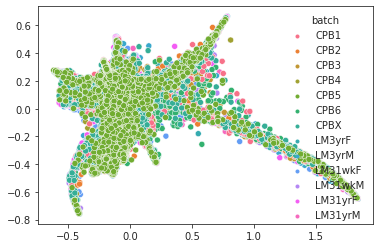

In [72]:
import phate
data_phate = phate.PHATE(gamma=0, knn_dist='precomputed').fit_transform(G.K)


<AxesSubplot:>

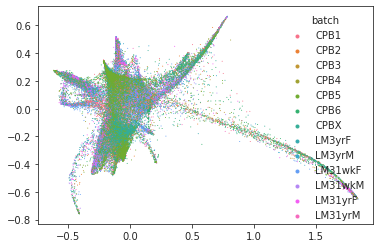

In [75]:
sns.scatterplot(x=data_phate[:, 0], 
                y=data_phate[:, 1], 
                hue=adata.obs['batch'],
                rasterized=True,
                linewidth=0, s=1)

<AxesSubplot:>

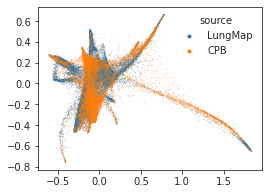

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))
sns.scatterplot(x=data_phate[:, 0], 
                y=data_phate[:, 1], 
                hue=adata.obs['source'],
                rasterized=True,
                linewidth=0, s=1, ax=ax, alpha=0.4)